In [1]:
import sys

moduleLoc = "C:\\Users\\tlsha\\PycharmProjects\\another-seq"
if moduleLoc in sys.path: 
    print('woo')
else:
    sys.path.append(moduleLoc)
import matplotlib.pyplot as plt
import tools
import pandas as pd
import seaborn as sns
import numpy as np

# Enable inline plotting
%matplotlib inline

In [2]:
#read tail files into a pd dataframe
import imp
imp.reload(tools)
folderLoc = "C:\\Users\\tlsha\\Dropbox\\NoctData\\"
controlName = "siLuc.tails"
KDname = "siNoct.tails"
WTname = "NoctWT.tails"
EAname = "NoctEA.tails"

control = tools.pdTailMaker(folderLoc+controlName)
print('Control In!')
knockdown = tools.pdTailMaker(folderLoc+KDname)
print('Knockdown In!')
WTaddback = tools.pdTailMaker(folderLoc+WTname)
print('WT In!')
EAaddback = tools.pdTailMaker(folderLoc+EAname)
print('EA In!')


Control In!
Knockdown In!
WT In!
EA In!


In [3]:
# Filter and combine tail data
minTail = -10
maxTail = 10
filtControl = control[(control['3Loc']+control['TailLength'])>=minTail]
filtControl = filtControl[(filtControl['3Loc']+filtControl['TailLength'])<=maxTail]
filtControl['Source'] = 'siLuc'

filtKD = knockdown[(knockdown['3Loc']+knockdown['TailLength'])>=minTail]
filtKD = filtKD[(filtKD['3Loc']+filtKD['TailLength'])<=maxTail]
filtKD['Source'] = 'siNoct'

filtWT = WTaddback[(WTaddback['3Loc']+WTaddback['TailLength'])>=minTail]
filtWT = filtWT[(filtWT['3Loc']+filtWT['TailLength'])<=maxTail]
filtWT['Source'] = 'WT Addback'

filtEA = EAaddback[(EAaddback['3Loc']+EAaddback['TailLength'])>=minTail]
filtEA = filtEA[(filtEA['3Loc']+filtEA['TailLength'])<=maxTail]
filtEA['Source'] = 'EA Addback'

# Combined experimental data
combo = pd.concat([filtControl,filtKD,filtWT,filtEA],ignore_index=True)
combo['TotalTail'] = combo['3Loc'] + combo['TailLength']

print ("CONTROL\nInitial: {}\nFiltered: {}\n".format(len(control),len(filtControl)))
print ("KNOCKDOWN\nInitial: {}\nFiltered: {}\n".format(len(knockdown),len(filtKD)))
print ("WT\nInitial: {}\nFiltered: {}\n".format(len(WTaddback),len(filtWT)))
print ("EA\nInitial: {}\nFiltered: {}\n".format(len(EAaddback),len(filtEA)))
combo.set_index('Gene', inplace=True)
combo.to_csv('combo.csv')

combo.head()

CONTROL
Initial: 3903782
Filtered: 1351776

KNOCKDOWN
Initial: 4621080
Filtered: 1324006

WT
Initial: 2411894
Filtered: 759185

EA
Initial: 2579469
Filtered: 779416



,3Loc,TailLength,TailSeq,Type,Source,TotalTail
Gene,,,,,,
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0


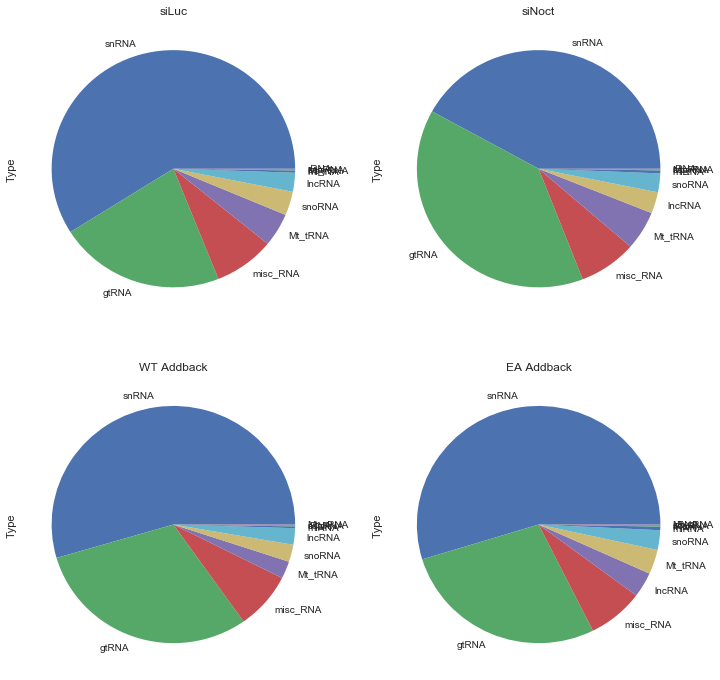

In [92]:
#Find a better way to represent this data
f, axarr = plt.subplots(2,2, figsize=(12,12), )
axarr[0,0].set_title("siLuc")
axarr[0,1].set_title("siNoct")
axarr[1,0].set_title("WT Addback")
axarr[1,1].set_title("EA Addback")

filtControl['Type'].value_counts().plot(kind='pie',ax=axarr[0,0])
filtKD['Type'].value_counts().plot(kind='pie',ax=axarr[0,1])
filtWT['Type'].value_counts().plot(kind='pie', ax=axarr[1,0])
filtEA['Type'].value_counts().plot(kind='pie',ax=axarr[1,1])

In [93]:
def TPMmaker(df, source, totalReads):
    df = df.set_index('Gene')
    df.head()
    names = set(df.index)
    out = []
    # 'Gene', 'Source', 'Count', 'TPM'
    for name in names:
        out.append([name,
                    source,
                    df.loc[[name]]['Type'].values[0],
                    len(df.loc[[name]]),
                    len(df.loc[[name]])/(totalReads/1000000)])
    print(source + " finished.")
    return pd.DataFrame(out, columns = ["Gene",'Type','Source','Count','TPM'])

TPM = pd.concat([TPMmaker(filtControl,"siLuc",len(control)),
           TPMmaker(filtKD, "siNoct", len(knockdown)),
           TPMmaker(filtWT,"WT Addback",len(WTaddback)),
           TPMmaker(filtEA, "EA Addback", len(EAaddback))],
          ignore_index=True)

TPM.to_csv('TPM.csv')

siLuc finished.
siNoct finished.
WT Addback finished.
EA Addback finished.


In [94]:
# Can read in from saved CSVs
TPM = pd.read_csv('TPM.csv',index_col=0)
combo = pd.read_csv('combo.csv',index_col=0)


In [65]:
#Find candidates using TPM, saves candidates based on a maturation hypothesis and a decay hypothesis
matCans = []
decayCans = []
names = list(set(TPM['Gene']))
df1 = TPM[TPM['Source']=='siLuc']
df2 = TPM[TPM['Source']=='siNoct']
df3 = TPM[TPM['Source']=='WT Addback']
df4 = TPM[TPM['Source']=='EA Addback']

for name in names:
    try:
        siLuc = (df1[df1['Gene']==name]['TPM']).values[0]
        siNoct = (df2[df2['Gene']==name]['TPM']).values[0]
        WT = (df3[df3['Gene']==name]['TPM']).values[0]
        EA = (df4[df4['Gene']==name]['TPM']).values[0]
    except:
        continue
    
    #Changes in TPM preicted by different models
    if siLuc > siNoct and siLuc > EA and siNoct < WT and WT > EA: matCans.append([name,siLuc,siNoct,WT,EA])
    if siLuc < siNoct and siLuc < EA and siNoct > WT and WT < EA: decayCans.append([name,siLuc,siNoct,WT,EA])
        
pd.DataFrame(matCans, columns=['Gene','siLuc','siNoct','WT','EA']).to_csv('Maturation_Candidates.csv')
pd.DataFrame(decayCans, columns=['Gene','siLuc','siNoct','WT','EA']).to_csv('Decay_Candidates.csv')

In [ ]:
df = pd.read_csv(folderLoc+"NoctVsWT_candidates.csv",index_col=False)
df.head(10)

In [ ]:
df = filtControl[filtControl['Gene'].str.contains('Mt_tRNA')]

In [ ]:
plt.figure(figsize=(20,20))
df = filtControl[filtControl['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='blue')

df = filtKD[filtKD['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='green')

df = filtWT[filtWT['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='red')

df = filtEA[filtEA['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='yellow')

#Cumulative plot of mitochondrial tRNA lengths

In [ ]:
plt.figure(figsize=(20,20))
df = filtControl[filtControl['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='blue')

df = filtKD[filtKD['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='green')

df = filtWT[filtWT['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='red')

df = filtEA[filtEA['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='yellow')

#cumulative plots of tRNA

In [ ]:
df1 = filtControl[filtControl['Gene'].str.contains('gtRNA')]
df2 = filtKD[filtKD['Gene'].str.contains('gtRNA')]
df3 = filtWT[filtWT['Gene'].str.contains('gtRNA')]
df4 = filtEA[filtEA['Gene'].str.contains('gtRNA')]


In [ ]:
#TPM Calculations
df1 = filtControl[filtControl['Gene'].str.contains('tRNA')]
TPM1 = pd.DataFrame(df1['Gene'].value_counts()).rename(columns={'Gene':'Count'})
TPM1['Source'] = 'Control'
TPM1['TPM'] = TPM1['Count']/(len(filtControl)/1000000)

df2 = filtKD[filtKD['Gene'].str.contains('tRNA')]
TPM2 = pd.DataFrame(df2['Gene'].value_counts()).rename(columns={'Gene':'Count'})
TPM2['Source'] = 'siNoct'
TPM2['TPM'] = TPM2['Count']/(len(filtKD)/1000000)

df3 = filtWT[filtWT['Gene'].str.contains('tRNA')]
TPM3 = pd.DataFrame(df3['Gene'].value_counts()).rename(columns={'Gene':'Count'})
TPM3['Source'] = 'WT Addback'
TPM3['TPM'] = TPM3['Count']/(len(filtWT)/1000000)

df4 = filtEA[filtEA['Gene'].str.contains('tRNA')]
TPM4 = pd.DataFrame(df4['Gene'].value_counts()).rename(columns={'Gene':'Count'})
TPM4['Source'] = 'EA Addback'
TPM4['TPM'] = TPM4['Count']/(len(filtEA)/1000000)


dude = pd.concat([TPM1,TPM2,TPM3,TPM4])
ind = dude.index[:5]
dude=dude.ix[ind]
dude

In [ ]:
plt.figure(figsize=(20,20))
sns.barplot(dude.index,dude.TPM,data=dude,hue='Source')
plt.xticks(rotation=-90)


In [ ]:
sns.barplot?

In [ ]:
pd.DataFrame?

In [ ]:
pd.DataFrame.loc?

In [95]:
plt.xticks?